# Vision Transformer Classification of Time Series Data Encoded as Image Fields #

We aim to distinguish between Robusta and Arabica coffee beans.

The vision transformer achieves 100% accuracy on test/valid and previously unseen data. 

The UCR Datasets are somwhat trivial datasets that often have small sample sizes, class imbalances, etc. The Aretas platform has a streamlined ETL system for loading time series datasets, performing feature scaling, augmentations, class balancing (via augments) and train/test split class stratification (to prevent imbalances triggered by randomized train/test splits that are sampled randomly without considering class distributions). 

Augmentation helps reduce training epochs and increase robustness of the classifier. 

Additionally, we can correct training set imbalances by augmenting by supplementation. For example if we strive to have 50 samples per class, and original class counts are as follows:

Class 1: 20 samples
Class 2: 15 samples
Class 3: 35 samples

Then Class 1 will receive 30 augmented samples, Class 2 will receive 35 augmented samples and Class 3 will receive 15 augmented sample, such that each class will now have 50 total train samples. 

Our data preparation process is as follows:

<img src="UCR-Coffee-Data-Prep.png" />

### Coffee Spectrographs ###

> Food spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The coffee data set is a two class problem to distinguish between Robusta and Aribica coffee beans. Further information can be found in the original paper Briandet et al. Discrimination of Arabica and Robusta in Instant Coffee by Fourier Transform Infrared Spectroscopy and Chemometrics J. Agricultural and Food Chemistry, 44 (1), 1996. The data was first used in the time series classification literature in Bagnall et al. Transformation Based Ensembles for Time Series Classification, SDM 2012.

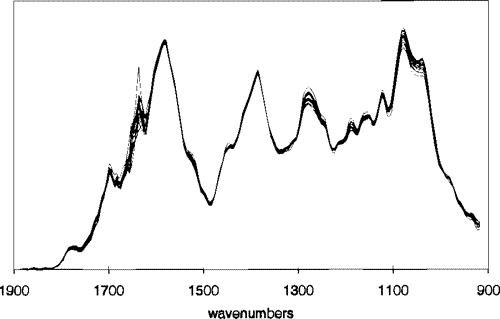

In [85]:
from fastai.vision.all import *
from numpy import genfromtxt

raw_file_data = genfromtxt('Coffee_TRAIN_TEST.csv', delimiter=',', dtype=str)

## Visualize the unprocessed data for all samples ##

In [86]:
def process_raw_data(raw_data):
    """Process the raw data from the CSV file - the last column has a data value and the label"""
    new_data = []
    for row in raw_data:
        new_row = row[0:-1].astype(float).tolist()

        # last col contains a value and the label
        tmp = row[-1]
        toK = tmp.split(':')
        # append the last data value
        new_row.append(float(toK[0]))
        # append the label
        new_row.append(int(toK[1]))
        # we're done parsing this row, append it to the new data
        new_data.append(new_row)

    return new_data


def get_distinct_labels(src_data):
    """Get the distinct labels from the dataset"""
    lbls = dict()
    for row in src_data:
        if row[-1] not in lbls:
            lbls[row[-1]] = row[-1]
    return lbls

def got_all(ref:dict, target:dict):
    """A function to check if we have all the class labels present in the target dict"""
    for ref_key in ref:
        if ref_key not in target:
            return False
    return True


def get_first_distinct_classes(lbls, data):
    """Get samples of the classes/labels"""
    class_samples = dict()
    count = 0
    for row in data:

        label = row[-1]

        if label not in class_samples:

            print("label:" + str(label) + " count:" + str(count))

            class_samples[label] = row[0:-1]

        if got_all(lbls, class_samples) is True:
            return class_samples
        count = count + 1

    # return partial
    return class_samples

In [87]:
processed_data = process_raw_data(raw_file_data)
# check length and confirm we get the label
len(processed_data), processed_data[0][-1]

(56, 0)

In [88]:
labels = get_distinct_labels(processed_data)
labels

{0: 0, 1: 1}

### Plot all the samples ###

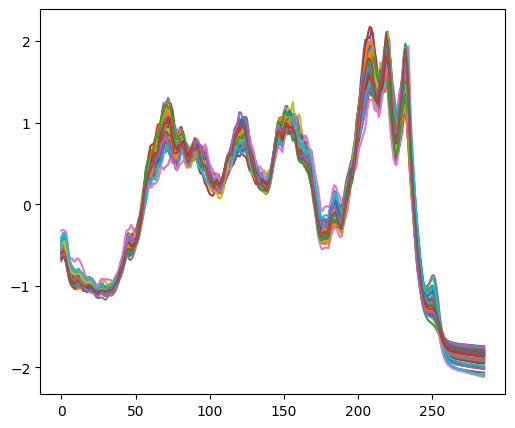

In [89]:
from IPython import display
import time as t

plt.figure(figsize=(6,5))
for ds in processed_data:
    plt.plot(range(len(ds[0:-1])), ds[0:-1])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    t.sleep(0.01)
# plt.legend()
plt.close();

### Visualize the class means separation ###

In [35]:
def get_class_variance(class_set):
    class_set_np = np.array(class_set)
    total_variance = 0.
    for i in range(class_set_np.shape[1]):
        col = class_set_np[:, i]
        total_variance += col.var()

    return total_variance


def get_set_mean(class_set):
    unlabeled = [i[0:-1] for i in class_set]
    """This returns an array of the same length as the items in class_set (mean of all items in the class)"""
    return np.mean(unlabeled, axis=0)


def get_class_counts(all_data, data_labels):

    totals_per_class = {}
    for k in data_labels:
        totals_per_class[k] = 0

    for row in all_data:
        kk = row[-1]
        totals_per_class[kk] = totals_per_class[kk] + 1

    return totals_per_class

In [36]:
class_means_dict = {}
for key in labels:
    class_samples = [i for i in processed_data if i[-1] == key]
    class_samples = class_samples[0:-1]
    class_means = get_set_mean(class_samples)
    class_means_dict[key] = np.array(class_means)

    print("Sum of class {} variance:{}".format(key, get_class_variance(class_samples)))

Sum of class 0 variance:2.1270612109330616
Sum of class 1 variance:1.9630248405040907


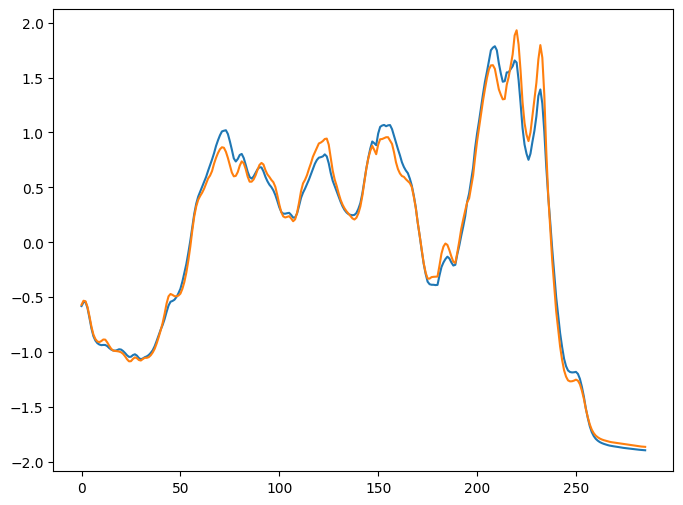

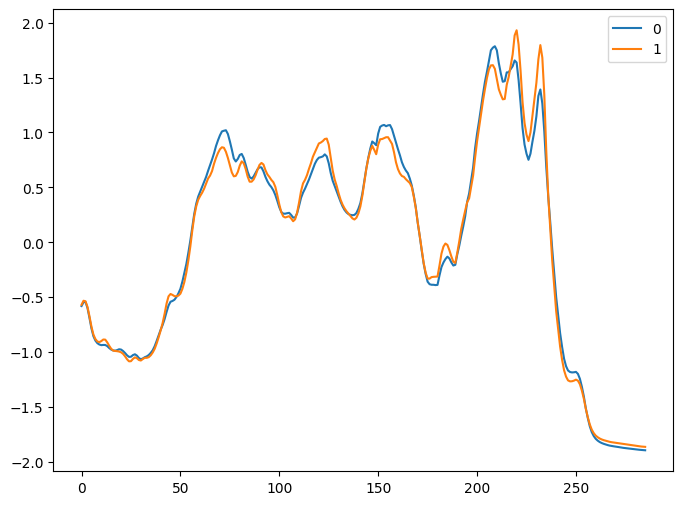

In [37]:
plt.figure(figsize=(8,6))
for key in class_means_dict:
    print('key:' + str(key))
    plt.plot(range(len(class_means_dict[key])), class_means_dict[key], label=str(key))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    t.sleep(0.2)
plt.legend()

## Train the Vision Transformer ##

We've previously exported the Image Fields of the sensor data. We'll train and test the Vision Transformer. 

In [38]:
root_path = Path("GAF-export/")
image_data_path = root_path /'train/'

In [39]:
image_data_path.ls()

(#2) [Path('GAF-export/train/0'),Path('GAF-export/train/1')]

In [40]:
files = get_image_files(image_data_path)

In [41]:
len(files)

228

In [42]:
files[0]

Path('GAF-export/train/0/1681185526187.png')

In [43]:
files[0].parts[len(files[0].parts) - 2]

'0'

In [44]:
def label_func(f):
    label = f.parts[len(f.parts) - 2]
    return label


In [45]:
print(label_func(files[0]))

0


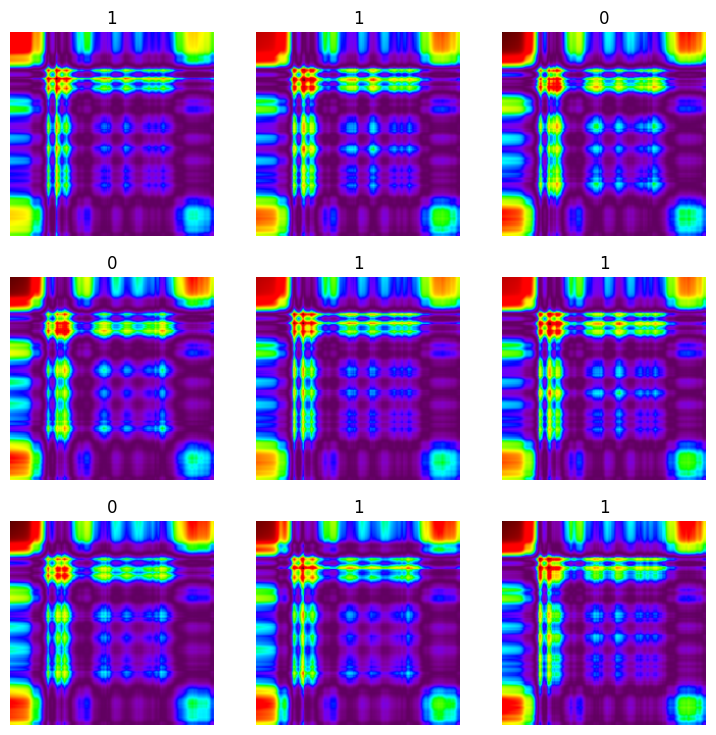

In [46]:
splitter = RandomSplitter(valid_pct=0.2)
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  get_y = label_func,
                  splitter = splitter,
                  item_tfms=Resize((200,200), ResizeMethod.Squish))
dls = dblock.dataloaders(image_data_path, bs=16)
dls.show_batch()

SuggestedLRs(valley=0.0006918309954926372)

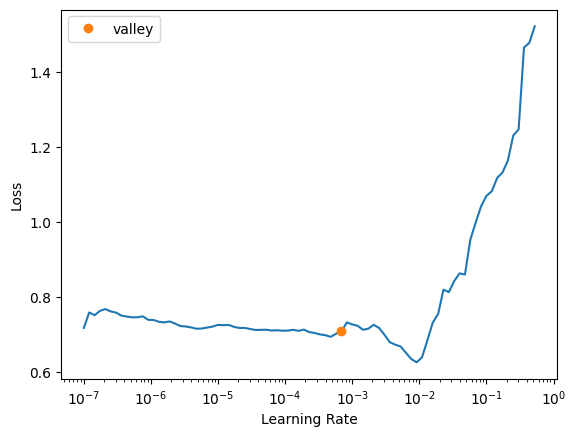

In [72]:
from vit_pytorch import ViT

v = ViT(
    image_size = 200,
    patch_size = 10,
    num_classes = 2,
    dim = 512,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

learn = Learner(dls, v, metrics=accuracy)
learn.lr_find(num_it=100)

In [74]:
lr =0.0006918309954926372
learn.fit_one_cycle(3,lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.434935,0.006031,1.000000,00:01
1,0.195677,0.000383,1.000000,00:01
2,0.115710,0.000123,1.000000,00:01


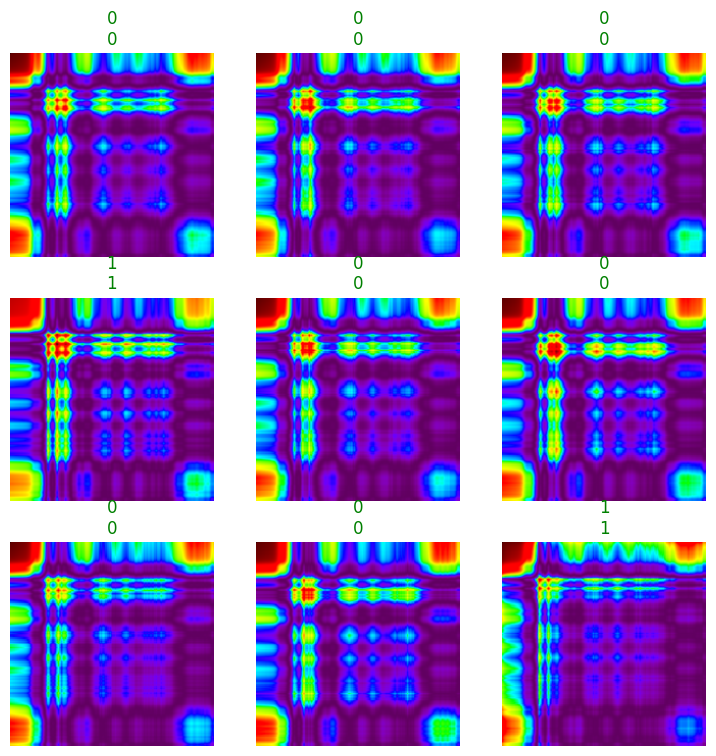

In [75]:
learn.show_results()

In [76]:
interp = Interpretation.from_learner(learn)

In [77]:
# with the accuracy > 95% and limited class size and sample size, there's no point in examining top losses
# interp.plot_top_losses(9, figsize=(15,10))

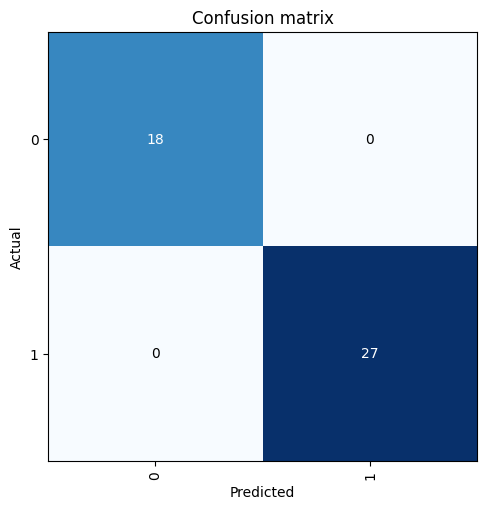

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100, linewidth=2)

In [79]:
learn.export("Coffee_species_model.pkl")

### Testing ###

We test on previously unseen data to see if we can generalize. Even though this is a small dataset, it's still worth testing.

In [80]:
test_set_path = root_path/'test'

test_set_images = get_image_files(test_set_path)
test_set_images, len(test_set_images)

((#18) [Path('GAF-export/test/0/1681185558131.png'),Path('GAF-export/test/0/1681185558268.png'),Path('GAF-export/test/0/1681185558402.png'),Path('GAF-export/test/0/1681185558535.png'),Path('GAF-export/test/0/1681185558667.png'),Path('GAF-export/test/0/1681185558799.png'),Path('GAF-export/test/0/1681185558938.png'),Path('GAF-export/test/0/1681185559091.png'),Path('GAF-export/test/0/1681185559221.png'),Path('GAF-export/test/1/1681185559362.png')...],
 18)

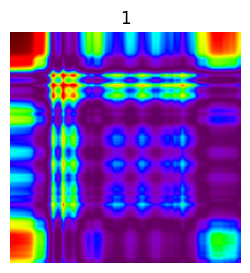

In [81]:
test_learn = load_learner("Coffee_species_model.pkl")
#I don't think we can stratify easily across imbalanced classes, even ones that have *close to* perfect balance
test_dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  get_y = label_func,
                  splitter = RandomSplitter(valid_pct=0.1))

test_dls = dblock.dataloaders(test_set_path, bs=1)
test_dls.show_batch()

In [82]:
print(len(test_dls.valid), len(test_dls.train))
test_dls.valid = test_dls.train
print(len(test_dls.valid), len(test_dls.train))

3 15
15 15


In [83]:
# data_test=data_test.databunch()

# Set the validation set of the learner by the test data you created
#learn.data.valid_dl = data_test.valid_dl
test_learn.dls = test_dls

# Now y refers to the actual labels in the data set
preds, y = test_learn.get_preds()
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc * 100))

The accuracy is 100.0 %.


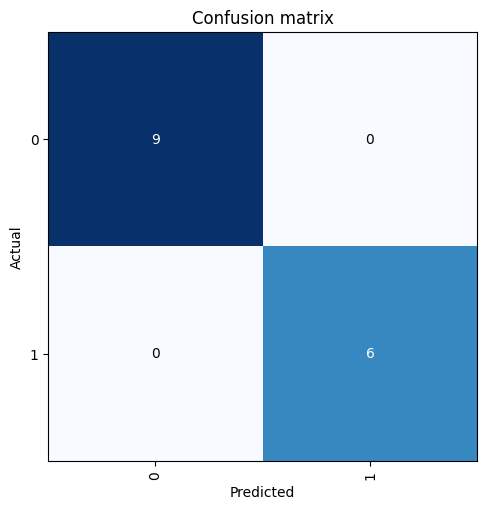

In [84]:
interp = ClassificationInterpretation.from_learner(test_learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100, linewidth=2)